<a href="https://colab.research.google.com/github/Adetayo047/Toby-s_DCNN_-with_attention_project/blob/main/tobyanother.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
cd /content/drive/MyDrive/tobi/archive

/content/drive/MyDrive/tobi/archive


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import numpy as np
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
def load_videos(video_folder, img_size=(28, 28)):
    data = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(os.listdir(video_folder))}

    for label in os.listdir(video_folder):
        video_label_folder = os.path.join(video_folder, label)

        for video_name in os.listdir(video_label_folder):
            video_path = os.path.join(video_label_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, img_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame / 255.0  # Normalize to [0, 1]
                data.append(frame)
                labels.append(label_map[label])
            cap.release()

    return np.array(data), np.array(labels)

video_folder = '/content/drive/MyDrive/tobi/archive/dataset/videos'
data, labels = load_videos(video_folder)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Data shape: (15084, 28, 28), Labels shape: (15084,)


In [7]:
import os
import cv2
import numpy as np


def load_videos(video_folder, img_size=(28, 28)):
  data = []
  labels = []
  # label_map = {label: idx for idx, label in enumerate(os.listdir(video_folder))} # we don't need to map index to label

  for label in os.listdir(video_folder):
    video_label_folder = os.path.join(video_folder, label)

    for video_name in os.listdir(video_label_folder):
      video_path = os.path.join(video_label_folder, video_name)
      cap = cv2.VideoCapture(video_path)

      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break
        frame = cv2.resize(frame, img_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame / 255.0  # Normalize to [0, 1]
        data.append(frame)
        labels.append(label) # append the folder name directly
      cap.release()

  return np.array(data), np.array(labels)

video_folder = '/content/drive/MyDrive/tobi/archive/dataset/videos'
data, labels = load_videos(video_folder)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Data shape: (15084, 28, 28), Labels shape: (15084,)


In [8]:
# prompt: i want to see the unique labels

import numpy as np

# ... (preceding code)

unique_labels = np.unique(labels)
print(unique_labels)


['crab' 'fish-big' 'fish-school' 'fish-small-shrimp' 'jellyfish']


In [9]:
import json

def load_annotations(annotation_files):
    annotations = {}
    for file in annotation_files:
        with open(file) as f:
            data = json.load(f)
            annotations.update(data)
    return annotations

annotation_files = [
    '/content/drive/MyDrive/tobi/archive/annotations/annotations_COCO/train_groundtruth.json',
    '/content/drive/MyDrive/tobi/archive/annotations/annotations_COCO/valid_groundtruth.json',
    '/content/drive/MyDrive/tobi/archive/annotations/annotations_COCO/test_groundtruth.json'
]
annotations = load_annotations(annotation_files)
print("Annotations loaded")


Annotations loaded


In [10]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ensure data and labels are numpy arrays
data = np.array(data)
labels = np.array(labels)

# Split data
train_images, temp_images, train_labels, temp_labels = train_test_split(data, labels, test_size=(1 - train_ratio), random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Train images shape: (10558, 28, 28), Train labels shape: (10558,)
Validation images shape: (3017, 28, 28), Validation labels shape: (3017,)
Test images shape: (1509, 28, 28), Test labels shape: (1509,)


In [11]:
# Create a mapping from labels to integers
label_to_index = {label: index for index, label in enumerate(np.unique(labels))}

# Convert string labels to integer labels
train_labels_encoded = np.array([label_to_index[label] for label in train_labels])
val_labels_encoded = np.array([label_to_index[label] for label in val_labels])
test_labels_encoded = np.array([label_to_index[label] for label in test_labels])

# Now you can use to_categorical
num_classes = len(label_to_index)
train_labels = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels_encoded, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

print(f"Train labels shape: {train_labels.shape}")

Train labels shape: (10558, 5)


In [12]:
#define a simple CNN model with attention mechanism

def cnn_with_attention_model(num_classes): # Add num_classes as argument
  model = models.Sequential()

  #convolutional layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # flatten the output for dense layers
  model.add(layers.Flatten())

  #intermediate feature
  intermedaite_features = model.layers[-1].output

  #attention mechanism
  attention_weights = layers.Dense(1, activation='relu')(intermedaite_features)
  attention_weights = layers.Reshape((1, 1, 1))(attention_weights)
  attended_features = layers.Multiply()([intermedaite_features, attention_weights])


  #dense layers
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax')) # Use num_classes here

  return model


#create the model
num_classes = 5 # Set the correct number of classes
model = cnn_with_attention_model(num_classes) # Pass num_classes to the model

model.summary()

#compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                1

In [14]:
# add 4 layer to the network and make it deep neural network

# ... (preceding code)

def cnn_with_attention_model(num_classes): # Add num_classes as argument
  model = models.Sequential()

  #convolutional layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # flatten the output for dense layers
  model.add(layers.Flatten())

  #intermediate feature
  intermedaite_features = model.layers[-1].output

  #attention mechanism
  attention_weights = layers.Dense(1, activation='relu')(intermedaite_features)
  attention_weights = layers.Reshape((1, 1, 1))(attention_weights)
  attended_features = layers.Multiply()([intermedaite_features, attention_weights])


  #dense layers
  model.add(layers.Dense(128, activation='relu')) # Added layer 1
  model.add(layers.Dense(256, activation='relu')) # Added layer 2
  model.add(layers.Dense(128, activation='relu')) # Added layer 3
  model.add(layers.Dense(64, activation='relu'))  # Added layer 4
  model.add(layers.Dense(num_classes, activation='softmax')) # Use num_classes here

  return model

# ... (rest of the code)


Epoch 1/10
165/165 [==============================] - 10s 63ms/step - loss: 0.4680 - accuracy: 0.8253 - val_loss: 0.4716 - val_accuracy: 0.8131
Epoch 2/10
165/165 [==============================] - 8s 48ms/step - loss: 0.4329 - accuracy: 0.8325 - val_loss: 0.4200 - val_accuracy: 0.8290
Epoch 3/10
165/165 [==============================] - 11s 64ms/step - loss: 0.3939 - accuracy: 0.8520 - val_loss: 0.3977 - val_accuracy: 0.8608
Epoch 4/10
165/165 [==============================] - 9s 56ms/step - loss: 0.3745 - accuracy: 0.8535 - val_loss: 0.3796 - val_accuracy: 0.8701
Epoch 5/10
165/165 [==============================] - 11s 69ms/step - loss: 0.3335 - accuracy: 0.8775 - val_loss: 0.3612 - val_accuracy: 0.8688
Epoch 6/10
165/165 [==============================] - 10s 64ms/step - loss: 0.3079 - accuracy: 0.8905 - val_loss: 0.3709 - val_accuracy: 0.8549
Epoch 7/10
165/165 [==============================] - 9s 54ms/step - loss: 0.2894 - accuracy: 0.8935 - val_loss: 0.3231 - val_accuracy: 0.

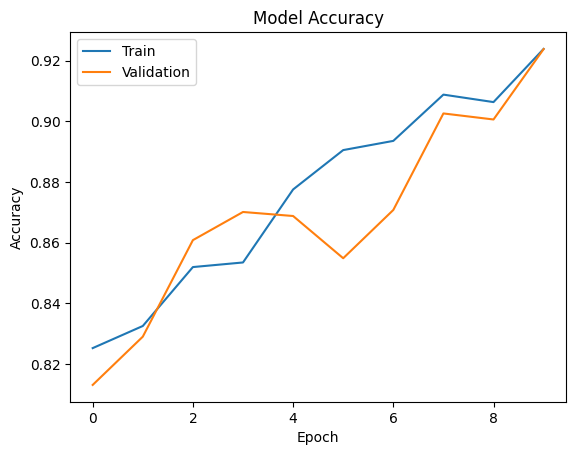

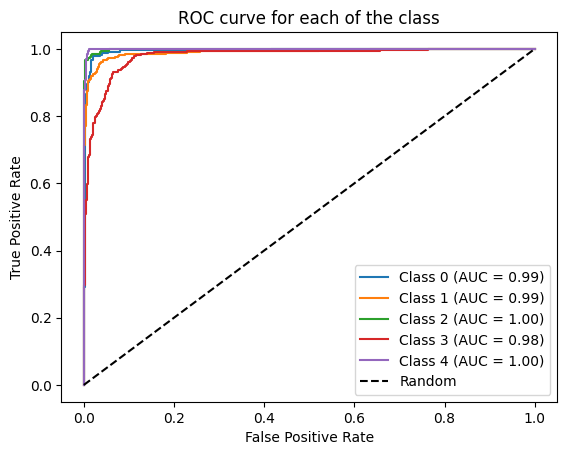

In [39]:
#train the model
history = model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_data=(test_images, test_labels))

#plot training and validation accuracy
plt.plot(history.history['accuracy'], label = "trainig accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show

#Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

#Predict probabilities for ROC curve
y_pred_prob = model.predict(test_images)

#compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Set the loop to iterate over the correct number of classes (5 in this case)
for i in range(num_classes): # Use num_classes instead of hardcoded 10
  fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred_prob[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

#plot ROC curves
plt.figure()
for i in range(num_classes): # Use num_classes instead of hardcoded 10
  plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each of the class')
plt.legend()
plt.show()

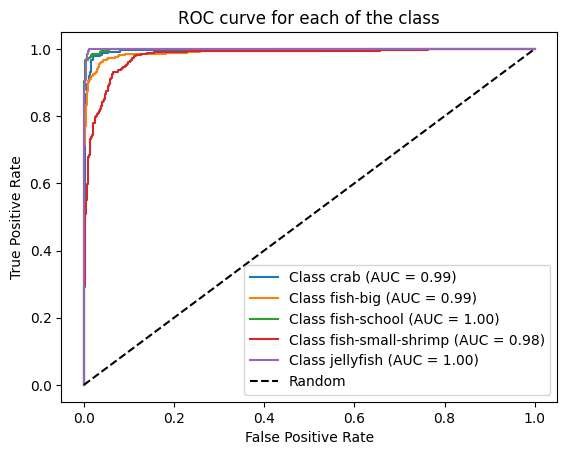

In [40]:
# prompt: i want to represent the class from 1 to 4 with the actual label from the data and use this to plot the daigram again

# ... (preceding code)

# Get the actual class labels from the label_to_index mapping
index_to_label = {index: label for label, index in label_to_index.items()}

# ... (rest of the code)

# Plot ROC curves with actual class labels
plt.figure()
for i in range(num_classes):
  plt.plot(fpr[i], tpr[i], label='Class %s (AUC = %0.2f)' % (index_to_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each of the class')
plt.legend()
plt.show()


In [41]:
# prompt: can you interprete the data

# ... (preceding code)

# Interpret the data
print("Model Evaluation:")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Interpret ROC AUC scores
print("\nROC AUC Scores:")
for i in range(num_classes):
    print(f"Class {index_to_label[i]}: {roc_auc[i]:.2f}")

# Analyze misclassifications (example)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(test_labels, axis=1)
misclassified_indices = np.where(y_pred != y_true)[0]

print("\nExample Misclassifications:")
for idx in misclassified_indices[:5]:  # Print first 5 misclassifications
    true_label = index_to_label[y_true[idx]]
    predicted_label = index_to_label[y_pred[idx]]
    print(f"Sample {idx}: True label: {true_label}, Predicted: {predicted_label}")

# Further analysis could include:
# - Confusion matrix to see class-wise performance
# - Visualizing misclassified images to understand common errors
# - Investigating feature importance or attention weights
# ...


Model Evaluation:
Test Accuracy: 92.38%

ROC AUC Scores:
Class crab: 0.99
Class fish-big: 0.99
Class fish-school: 1.00
Class fish-small-shrimp: 0.98
Class jellyfish: 1.00

Example Misclassifications:
Sample 21: True label: fish-small-shrimp, Predicted: crab
Sample 108: True label: fish-small-shrimp, Predicted: fish-big
Sample 109: True label: fish-big, Predicted: fish-small-shrimp
Sample 120: True label: fish-big, Predicted: fish-small-shrimp
Sample 129: True label: fish-big, Predicted: fish-small-shrimp


In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the cv2_imshow function

def process_frame(frame, img_size=(28, 28)):
  """Preprocesses a single frame for the model."""
  frame = cv2.resize(frame, img_size)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  frame = frame / 255.0  # Normalize to [0, 1]
  frame = np.expand_dims(frame, axis=0)  # Add batch dimension
  frame = np.expand_dims(frame, axis=-1) # Add channel dimension
  return frame

def predict_live_video(model, video_path, label_to_index, index_to_label):
  """Predicts classes for a live video stream."""
  cap = cv2.VideoCapture(video_path)

  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    processed_frame = process_frame(frame)
    prediction = model.predict(processed_frame)
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = index_to_label[predicted_class_index]

    # Display the frame with prediction
    cv2.putText(frame, f"Prediction: {predicted_class_label}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2_imshow(frame) # Use cv2_imshow instead of cv2.imshow

    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  cap.release()
  cv2.destroyAllWindows()

# Example usage:
video_path = '/content/drive/MyDrive/tobi/archive/dataset/videos/fish-school/2019-02-21_06-52-16to2019-02-21_06-52-34_1.avi'  # Replace with your video path
predict_live_video(model, video_path, label_to_index, index_to_label)

NameError: name 'model' is not defined

Adding 4 more layer to the network and make it deep neural network

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt

def cnn_with_attention_model(input_shape=(28, 28, 1), num_classes=10):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for dense layers
    model.add(layers.Flatten())

    # Intermediate feature
    intermediate_features = model.layers[-1].output

    # Attention mechanism
    attention_weights = layers.Dense(1, activation='relu')(intermediate_features)
    attention_weights = layers.Reshape((1,))(attention_weights)
    attended_features = layers.Multiply()([intermediate_features, attention_weights])

    # Dense layers
    model.add(layers.Dense(128, activation='relu')) # Added layer 1
    model.add(layers.Dense(256, activation='relu')) # Added layer 2
    model.add(layers.Dense(128, activation='relu')) # Added layer 3
    model.add(layers.Dense(64, activation='relu'))  # Added layer 4
    model.add(layers.Dense(num_classes, activation='softmax')) # Use num_classes here

    return model